## Test Image Masking
__Try to replace pure white pixels with other colors__

In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model, Model

%matplotlib inline

Using TensorFlow backend.


__Load Models__

In [2]:
watch_df = pd.read_csv('all_watch_info_with_indicators.csv')

In [3]:
f_path = 'all_pics/'
f_list = os.listdir(f_path)

In [4]:
mask_path = 'all_masks/'
mask_files = os.listdir(mask_path)

In [5]:
def prepare_image(image_name):
    im_watch = Image.open(f_path + starting_name)
    im_watch = im_watch.resize((299,299))
    im_watch_array = np.array(im_watch)
    
    return im_watch_array

In [6]:
def prepare_image_with_mask(image_name, mask_name):
    im_watch = Image.open(image_name)
    #im_watch = im_watch.resize((299,299))
    im_watch_array = np.array(im_watch)
    
    im_mask = Image.open(mask_name)
    im_mask = im_mask.resize((im_watch.size))
    im_mask_array = np.array(im_mask)
    
    is_white = (im_watch_array[:,:,0]>252) & \
        (im_watch_array[:,:,1]>250) & \
        (im_watch_array[:,:,1]>250) 
    
    is_white = np.dstack((is_white,is_white,is_white))
    
    im_watch_array[is_white == 1] = im_mask_array[is_white == 1]
    
    return im_watch_array

In [19]:
watch_f = f_path + np.random.choice(f_list)
mask_f =  mask_path + np.random.choice(mask_files)

In [20]:
im_watch_array = prepare_image_with_mask(watch_f,mask_f)

(-0.5, 263.5, 399.5, -0.5)

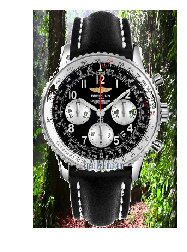

In [21]:
imgplot = plt.imshow(im_watch_array)
plt.axis('off')


__Test Recommendations__

In [51]:
good_files = []
for filename in glob.iglob('multi_class_testing/**/**/*.jpg', recursive=True):
    good_files.append(filename)

In [ ]:
for filename in good_files:
    
    new_file = 'binary_gender_masked/'
    check_mask = np.random.uniform(0,1)
    if check_mask > 0.5:
        good_files[0].split('/',1)
        

In [53]:
np.random.uniform(0,1)

0.49589163370243783

In [56]:
good_files[0].split('/',1)

['multi_class_testing',
 'train/male/6738_LonginesTheSaintImierChronograph41mmL27528723.jpg']

In [ ]:
! ls binary_gender_masked/